In [ ]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup


In [151]:
## Import Data

df_mots = pd.read_csv("./data/b_mot_cle.csv", encoding="utf8")
df_mots.info()
df_mot_entite = pd.read_csv("./data/num_mot_entite.csv", encoding="utf8")
df_mot_entite.info()
df_publis = pd.read_csv("./data/num_publis.csv", encoding="utf8")
df_publis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2542 non-null   int64 
 1   mot     2542 non-null   object
 2   valid   2542 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 59.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093 entries, 0 to 3092
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3093 non-null   int64  
 1   id_mot       3093 non-null   int64  
 2   id_publi     2234 non-null   float64
 3   id_ecriture  0 non-null      float64
 4   id_user      748 non-null    float64
 5   id_revue     76 non-null     float64
 6   id_numero    35 non-null     float64
 7   valid        3093 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 193.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data column

In [148]:
df_mots.head(20)

,id,mot,valid
0,1,systémique,1
1,2,data,1
2,4,FLE,1
3,6,plurilinguisme,1
4,7,enseignement bilingue,1
5,8,politique linguistique,1
6,9,acquisition,1
7,10,interaction,1
8,11,acquisition des langues étrangères,1
9,12,créolisation,1


In [69]:
# df_publis.set_index("id", inplace=True)
selection = df_mot_entite.id_mot == 6
publis = df_mot_entite[selection].id_publi.dropna().astype("int32").values
publis

array([  83,   84,   86,  172,  167,  229, 1540, 1542,   34, 1638])

In [101]:
print(df_publis.loc[publis].article)
df_publis.loc[publis].article.iloc[0]

83      &lt;blockquote&gt;\r\n&lt;p&gt;&amp;laquo;&amp...
84      &lt;h2&gt;Introduction&lt;/h2&gt;\r\n\r\n&lt;p...
86      &lt;h2&gt;Introduction&lt;/h2&gt;\r\n\r\n&lt;p...
172                                                   NaN
167     &lt;h2&gt;Introduction&lt;/h2&gt;\r\n\r\n&lt;p...
229     &lt;h2&gt;&lt;strong&gt;1. Introduction&lt;/st...
1540    &lt;p class=&quot;texte&quot; dir=&quot;ltr&qu...
1542    &lt;h1 dir=&quot;ltr&quot; id=&quot;heading1&q...
34      &lt;div class=&quot;WordSection1&quot;&gt;\r\n...
1638    &lt;p class=&quot;texte&quot;&gt;Jean Birnbaum...
Name: article, dtype: object


In [133]:
# import re
# string = df_publis.loc[publis].article.iloc[0]
# cleantext = BeautifulSoup(string).text

# for match in re.finditer(".*plurilinguisme*.",cleantext):
#     print(match.span())
#     s = match.span()
    

(37924, 38144)


In [555]:
import html 
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return html.unescape(cleantext)


data = list(df_publis.titre.dropna())
data = [cleanhtml(BeautifulSoup(string).text) for string in data]
print(len(data))
data[0]

1815


'Note de recherche-Le rôle de l’entrepreneuriat coopératif dans l’inclusion socioéconomique des femmes : Cas de la coopérative féminine des produits de la mer de Douira « COFEPROMER »'

In [601]:
def create_embedding(data):
    model = SentenceTransformer('stsb-xlm-r-multilingual')
    embeddings = model.encode(data, show_progress_bar=True)
    return embeddings

from sklearn.cluster import SpectralClustering, KMeans

def create_clusters(data, embeddings):

    umap_embeddings = umap.UMAP(n_neighbors=5, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='manhattan',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

#     cluster = SpectralClustering(n_clusters=30, eigen_solver=None, n_components=None).fit(umap_embeddings)
#     cluster = KMeans(n_clusters=50).fit(embeddings)

    
    umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    return result, cluster

def plot_clusters(result_df):
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result_df.loc[result.labels == -1, :]
    clustered = result_df.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#0a0909', s=5)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r')
    plt.colorbar()
    

In [557]:
embeddings = create_embedding(data)

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

In [577]:
len(embeddings[0])

768

In [602]:
result, cluster = create_clusters(data, embeddings)

D:\A756805\Anaconda3\envs\marathon\lib\site-packages\umap\spectral.py:255: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


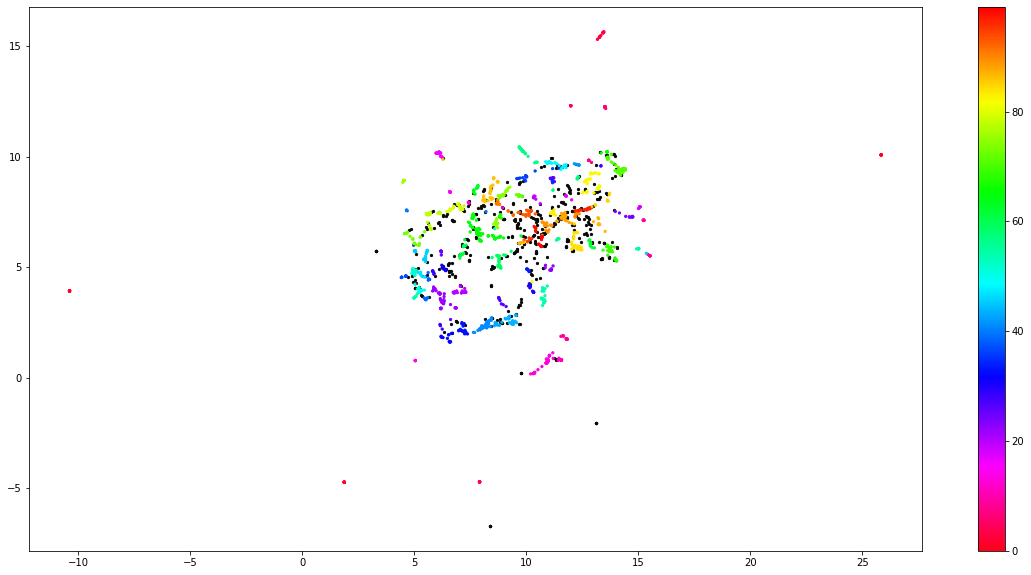

In [603]:
plot_clusters(result)

In [604]:
import stopwords

def lemma():
    pass


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords.STOP_WORDS, strip_accents='unicode').fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def get_n_topwords(data, cluster):
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    return top_n_words
    

top_n = get_n_topwords(data,cluster)

D:\A756805\Anaconda3\envs\marathon\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'cinquantieme', 'cinquieme', 'dela', 'deuxieme', 'deuxiemement', 'differente', 'dixieme', 'douzieme', 'ete', 'excepte', 'facon', 'he', 'huitieme', 'neuf', 'neuvieme', 'notres', 'onzieme', 'plutot', 'premiere', 'premierement', 'qu', 'quatrieme', 'quatriemement', 'quelqu', 'revoila', 'septieme', 'sixieme', 'troisieme', 'troisiemement', 've', 'voila', 'votres'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [605]:
cluster.labels_

array([-1, 31, -1, ..., 52, 85, 38], dtype=int64)

In [613]:
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame({"titre":data,"cluster":cluster.labels_})
select = results.cluster == 10
results[select]

,titre,cluster
46,"L'offense à la chair, ou l'emblème de la déshumanisation. Regards sur l'oeuvre guerrière d'Otto Dix",10
749,Contra la dominacion,10
1149,"Contre-révolution, folklore et provincialisme",10
1232,"Authoritarianism, social dominance and social values: Group-based dominance and opposition to equality as independent factors",10
1289,Anarchisme et nature humaine : domination contre autonomie,10
1394,A política nômade : a guerrilha contra o Estado,10
1457,Anarchisme et nature humaine : domination contre autonomie,10
1592,La transaction de la liberté et les nouvelles servitudes : somatophobie et autophobie,10


In [616]:
print(len(top_n))
top_n[10][:10]

101


[('contre', 0.26945927322938856),
 ('dominance', 0.24635494069349392),
 ('domination', 0.24635494069349392),
 ('autonomie', 0.23529024559919465),
 ('contra', 0.22670780131787888),
 ('humaine', 0.21376656144783224),
 ('nature', 0.2000482943732656),
 ('anarchisme', 0.19303592680426737),
 ('and', 0.18710705450321893),
 ('social', 0.15298000854164578)]

In [ ]:
# Néttoyer les langues
# Lemmatisation


In [23]:

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [24]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
3,2,727
0,-1,164
2,1,72
1,0,37
